
* Let us do the step by step solution...


#### 1. Cost Hamiltonian $H_2$:


* Following the discussion from previous class, we have that:

$$f(x_1, x_2, x_3) = 3x_1+2x_2-3x_3 + 2x_1x_2 - x_2x_3 \rightarrow H_2 =  \frac{3}{1} \left(\bar{I}-Z_1\right) + \frac{2}{1} \left(\bar{I}-Z_2\right) - \frac{3}{1} \left(\bar{I}-Z_3\right) + \frac{2}{1} \left(\bar{I}-Z_1-Z_2+ZZ_{12}\right)-\frac{1}{1} \left(\bar{I}-Z_2-Z_3+ZZ_{23}\right)$$

* Combining terms, we obtain:

$$f(x_1, x_2, x_3) = 3x_1+2x_2-3x_3 + 2x_1x_2 - x_2x_3 \rightarrow H_2 =  -\frac{5}{1}Z_1 -  \frac{3}{1} Z_2 + \frac{4}{1} Z_3 +\frac{2}{1}ZZ_12+ ZZ_{23}$$


#### 2. Hamiltonian $H_1$:

* This is much simpler as we just need to generate a line of RX gates in the circuit


#### 3. Build the Quantum Circuit:

In [2]:
from qiskit import QuantumCircuit
from qiskit import Aer
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

In [3]:
def CircuitGenerator(params):
    # params is a list:
    # First half of the list are betas, second half are gammas
   
    # Number of qubits
    nqubits = 3 
    
    # Number of alternating unitaries
    p = len(params) // 2
    
    qc = QuantumCircuit(nqubits)
    
    beta = params[:p] # for H1, first half, 0...p
    gamma = params[p:] # for H2, second half, p...end *(2p)
    
    # Initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    qc.barrier()
    
    # Apply H2, then H1, then H2, etc...
    for irep in range(0, p):
        # H2
        qc.rz(2 * -5 * gamma[irep], 0) # X1 ==> -3*x1
        qc.rz(2 * -3 * gamma[irep], 1) # X2 ==> 5*x2
        qc.rz(2 * 4 * gamma[irep], 2) # X3 ==> x3
        qc.cx(1, 2) # Control X, where qubit 1 (x2) controls qubit 2 (x3)
        qc.rz(2 * 2 * gamma[irep], 2) # Rotation Z on qubit 2 (x3)
        qc.cx(1, 2) # Control X, where qubit 1 (x2) controls qubit 2 (x3)
        qc.cx(1, 2) # Control X, where qubit 1 (x2) controls qubit 2 (x3)
        qc.rz(2 * 1 * gamma[irep], 2) # Rotation Z on qubit 2 (x3)
        qc.cx(1, 2) # Control X, where qubit 1 (x2) controls qubit 2 (x3)
        qc.barrier()
        
        # H1
        for i in range(0, nqubits): # A for on the number of variables (qubits) for each time step.
            qc.rx(2 * beta[irep], i)
        
        qc.barrier()
        
    qc.measure_all()
    qc.draw(output = 'mpl')
        
    return qc

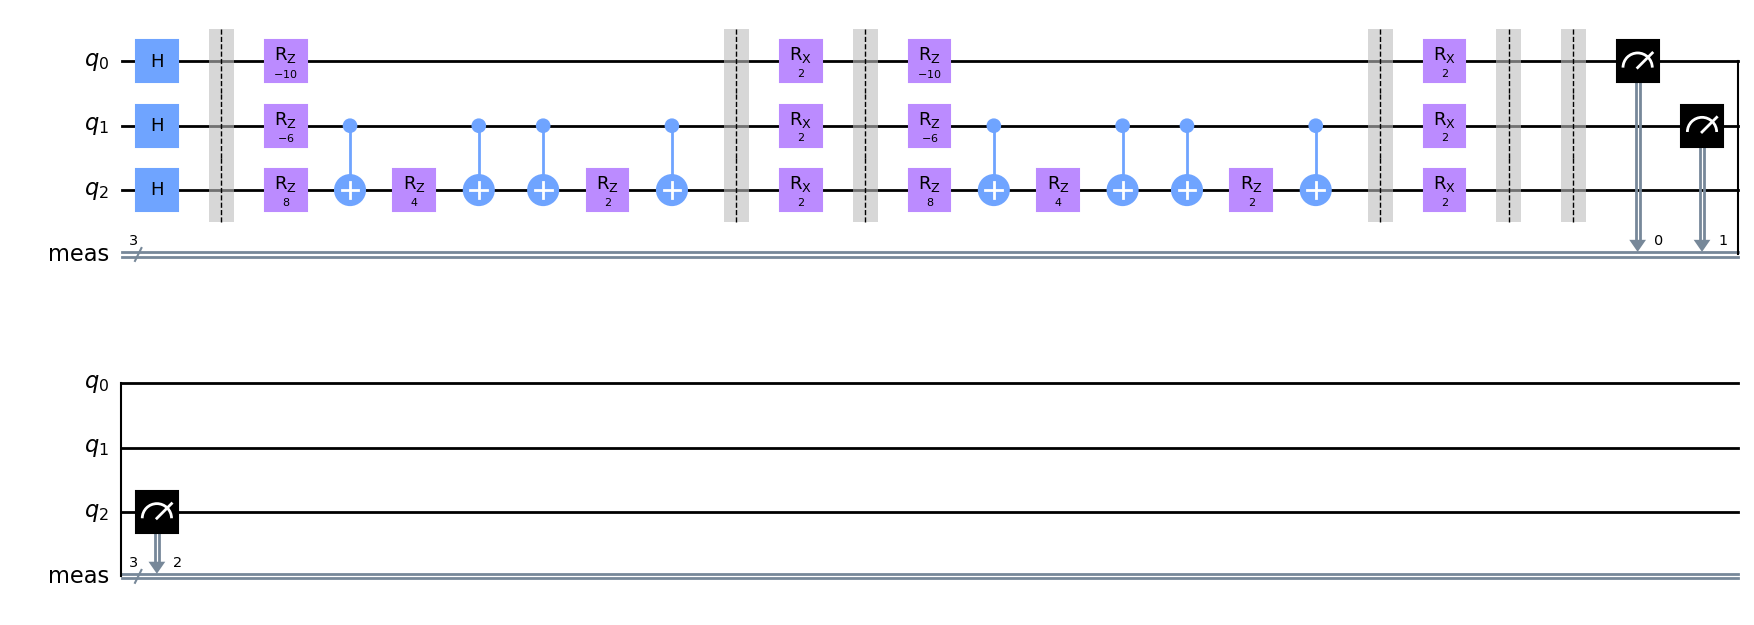

In [4]:
# Let us try it
qc = CircuitGenerator([1.0, 1.0, 1.0, 1.0]) # Passing some intial values for beta's and gamma's

# The resulting circuit is generated for just 2 time steps (p = 2), because we just passed 2 gammas and 2 betas.

qc.draw(output = 'mpl')

{'101': 220, '000': 25, '111': 318, '010': 69, '100': 81, '011': 134, '110': 96, '001': 81}


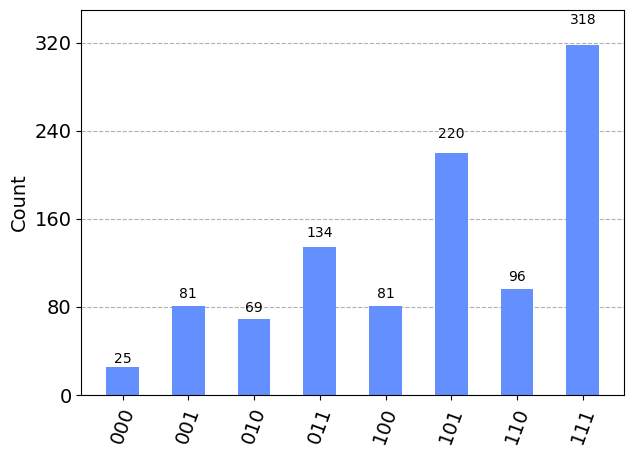

In [5]:
# Run and plot histogram: for results from just 1 pass of the QAOA (with initial values of betas and gammas)
backend = Aer.get_backend('aer_simulator')

counts = backend.run(qc).result().get_counts()

print(counts)

plot_histogram(counts)

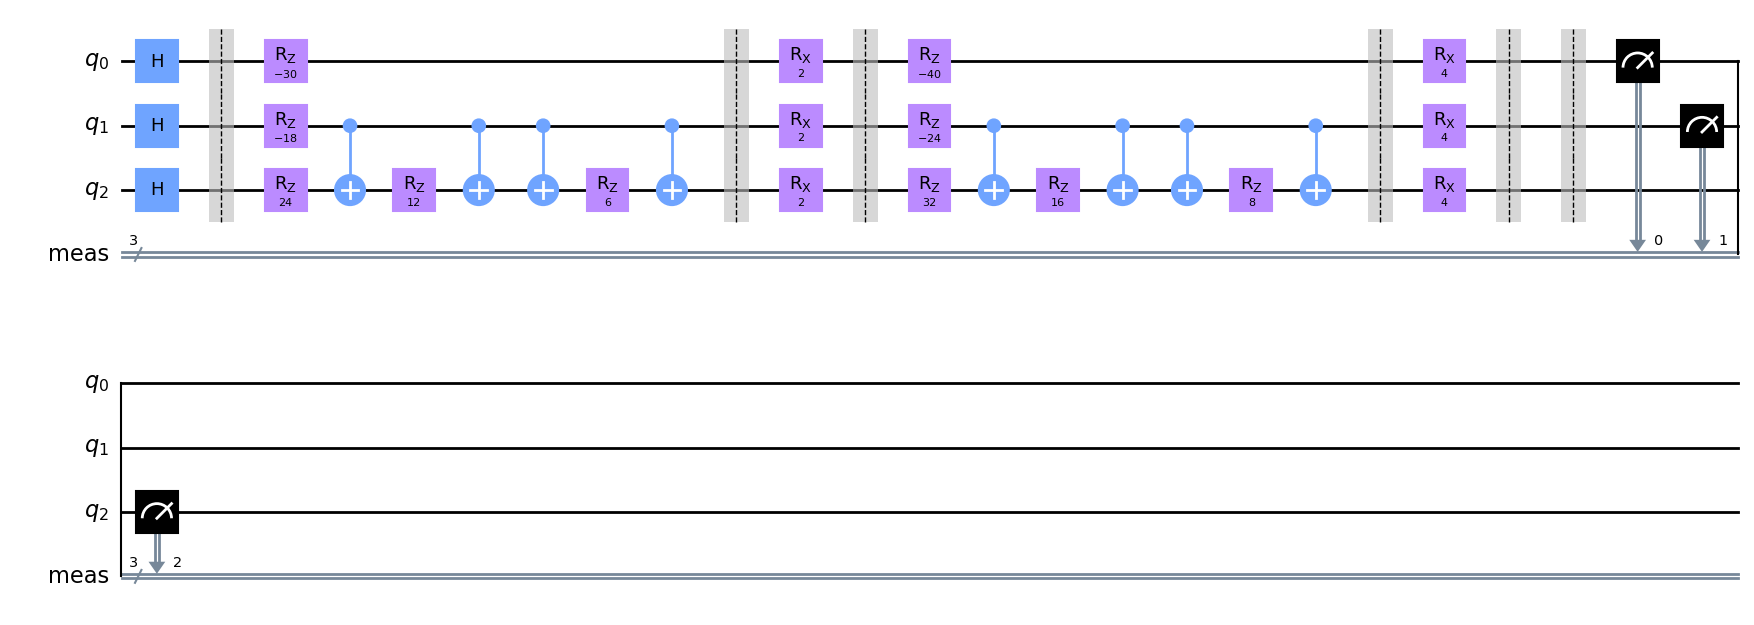

In [6]:
# Let us try it
qc = CircuitGenerator([1, 2, 3, 4, 5]) # Passing some intial values for beta's and gamma's

# The resulting circuit is generated for just 2 time steps (p = 2), because we just passed 2 gammas and 2 betas.

qc.draw(output = 'mpl')

{'011': 570, '010': 92, '001': 25, '101': 17, '111': 264, '110': 49, '000': 4, '100': 3}


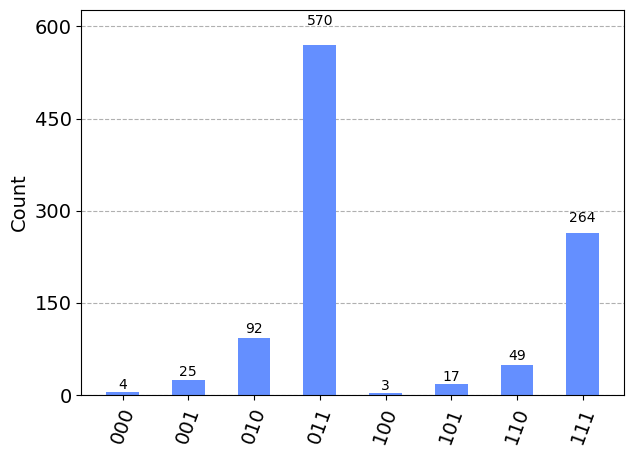

In [7]:
# Run and plot histogram: for results from just 1 pass of the QAOA (with initial values of betas and gammas)
backend = Aer.get_backend('aer_simulator')

counts = backend.run(qc).result().get_counts()

print(counts)

plot_histogram(counts)

In [8]:
#PROBLEM 3

# Define the objective function in the Real domain
# We need to evaluate each potential solution measured from the QC via the objective fucntion
# And then, we tune (optimize the gammas and betas)

def obj_function(x1, x2, x3):
    return 3 * x1 + 2 * x2 - 3* x3 + 2 * x1 * x2 - x2 * x3

In [9]:
def compute_expectation(params):

    foo = 0
    bar = 0
    
    qc = CircuitGenerator(params)
    backend = Aer.get_backend('aer_simulator')
    counts = backend.run(qc).result().get_counts()
    
    for key, item in counts.items():
        foo += obj_function(*[float(i) for i in list(key)]) * item
        bar += item
        
    return foo / bar

In [12]:
#params = np.random.uniform(0, 2 * np.pi, 4) # 4 is the total number of gammas and betas
params = [1,2,3,4,5]
res = minimize(compute_expectation, params, method = 'COBYLA')

print(res)
print(params)

     fun: -1.4365234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 55
  status: 1
 success: True
       x: array([1.35540181, 2.16987866, 2.88828768, 3.90922439, 4.88017002])
[1, 2, 3, 4, 5]


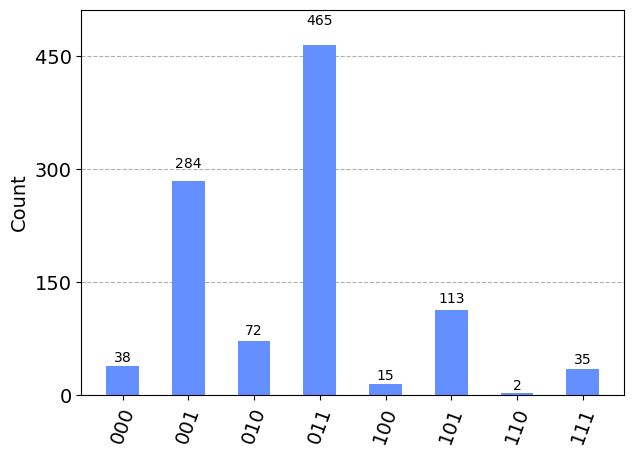

In [13]:
qc = CircuitGenerator(res.x)

backend = Aer.get_backend('aer_simulator')

counts = backend.run(qc).result().get_counts()

plot_histogram(counts)